In [1]:
import os
import urllib # 웹에서 데이터 다운할때 서용
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(3085, 2314, 3)


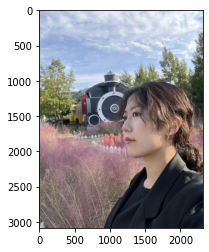

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 1. 세그멘터이션
이미지에서 사람과 피사체 분리하기 <br>
포토샵에서 '누끼 따기'랑 비슷

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb8ec2ea430>)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# PASCAL VOC 데이터로 학습된 모델을 이용한다
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해보자

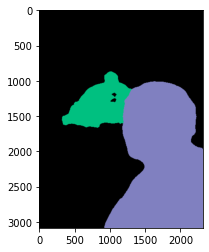

In [7]:
# 모델에서 나온 출력값 확인
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15, 19]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [9]:
# 라벨 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
train


In [10]:
# 물체마다 output에 어떤 색상으로 나타나는지 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
print(colormap[0]) # background
print(colormap[19]) # 기차

# 사람을 나타내는 15번째 색상 확인
print(colormap[15])

[0 0 0]
[128 192   0]
[192 128 128]


output 이미지가 BGR 순서로 채널 배치가 되어 있다. <br>
하지만 colormap은 RGB 순서이다. <br>
추출해야 하는 색상 값은 순서 바꿔주자!

In [12]:
# 색상값 순서 바꾸기
seg_color = (128,128,192)

(3085, 2314)


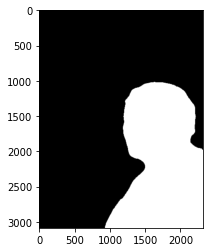

In [13]:
# seg_color로만 이루어진 마스크를 만들어 보자
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

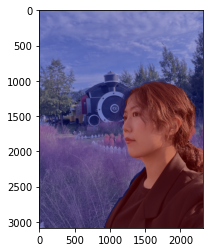

In [14]:
# 원래 이미지와 겹쳐보기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# blur() 함수로 배경 흐리게 만들기

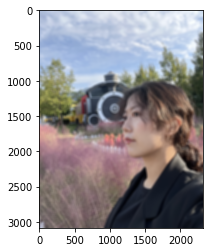

In [15]:
# (15,15) : blurring kernel size
img_orig_blur = cv2.blur(img_orig, (40,40))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

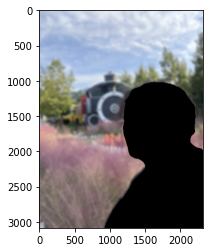

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 흐린 배경과 원본 영상 합성

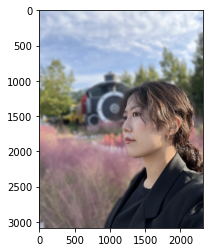

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()